In [2]:
# -*- coding: utf-8 -*-
"""MobileNet_Model.ipynb"""

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

from google.colab import drive
drive.mount('/content/drive')

!pip install tensorflow-addons
!pip install tensorflow

Saving alzheimers-dataset-4-class-of-images-metadata.json to alzheimers-dataset-4-class-of-images-metadata (1).json
User uploaded file "alzheimers-dataset-4-class-of-images-metadata (1).json" with length 3446 bytes
mv: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images
License(s): ODbL-1.0
alzheimers-dataset-4-class-of-images.zip: Skipping, found more recently modified local copy (use --force to force download)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
from zipfile import ZipFile
import os, glob
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

print("TensorFlow Version:", tf.__version__)


TensorFlow Version: 2.15.0


In [4]:



file_name = "/content/alzheimers-dataset-4-class-of-images.zip"
with ZipFile(file_name, 'r') as zip:
    zip.extractall("/content/")
    print('Done')
    extracted_dir = "/content/Alzheimer_s Dataset"
print("Contents of extracted directory:")
print(os.listdir(extracted_dir))

AUTOTUNE = tf.data.experimental.AUTOTUNE
base_dir = "/content/Alzheimer_s Dataset"
train_dir = os.path.join(extracted_dir, "train")
test_dir = os.path.join(extracted_dir, "test")

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']
IMG_SIZE = 224
IMAGE_SIZE = [224, 224]
DIM = (IMG_SIZE, IMG_SIZE)

BATCH_SIZE = 32

Done
Contents of extracted directory:
['train', 'test']


In [5]:

# Set a random seed for reproducibility
seed_value = 1337

# Create separate data generators for training and validation with augmentation
train_datagen = IDG(
    rescale=1./255,
    zoom_range=[.99, 1.01],
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    fill_mode='constant',
    validation_split=0.2,
    data_format='channels_last'
)

train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Assuming you're doing multi-class classification
    subset='training',
    seed=seed_value
)


Found 4098 images belonging to 4 classes.


In [6]:

val_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Assuming you're doing multi-class classification
    subset='validation',
    seed=seed_value
)


Found 1023 images belonging to 4 classes.


<ipython-input-7-ee5e9183d753>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Category', y='Count', data=data, palette='viridis')


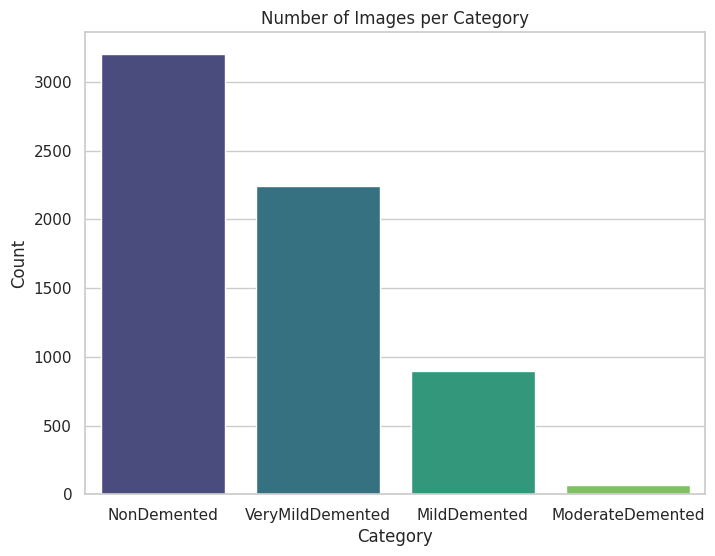

In [7]:


# Count images per category
datasets = ["train", "test"]
counts = {cls: 0 for cls in CLASSES}
for dataset in datasets:
    for cls in CLASSES:
        counts[cls] += len(glob.glob(os.path.join(extracted_dir, dataset, cls, '*.jpg')))

data = {'Category': list(counts.keys()), 'Count': list(counts.values())}
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Category', y='Count', data=data, palette='viridis')
ax.set_title('Number of Images per Category')
plt.show()

# Class weights
total_samples = sum(counts.values())
class_weights = {i: total_samples / (4 * count) for i, count in enumerate(counts.values())}


In [8]:

# New section: MobileNet model with the same data augmentation
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization

# Load the MobileNet model
base_model = MobileNet(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights="imagenet")

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-15:]:
    layer.trainable = True

In [9]:


# Create a new model on top
model_mobilenet = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(len(CLASSES), activation='softmax')
])


In [10]:
# Compile the model
model_mobilenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

# Print the model summary
model_mobilenet.summary()

# Set up callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

In [11]:


# Train the model
history_mobilenet = model_mobilenet.fit(
    train_ds,
    steps_per_epoch=train_ds.samples // BATCH_SIZE,
    epochs=30,
    validation_data=val_ds,
    validation_steps=val_ds.samples // BATCH_SIZE,
    class_weight=class_weights,  # Utilize the calculated class weights
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/30
128/128 [==============================] - 86s 529ms/step - loss: 16.1848 - accuracy: 0.2939 - val_loss: 1.8122 - val_accuracy: 0.1986 - lr: 1.0000e-04
Epoch 2/30
128/128 [==============================] - 68s 528ms/step - loss: 13.0957 - accuracy: 0.3490 - val_loss: 1.8775 - val_accuracy: 0.1240 - lr: 1.0000e-04
Epoch 3/30
128/128 [==============================] - 58s 450ms/step - loss: 10.2401 - accuracy: 0.3957 - val_loss: 1.9777 - val_accuracy: 0.2409 - lr: 1.0000e-04
Epoch 4/30
128/128 [==============================] - 67s 521ms/step - loss: 8.6650 - accuracy: 0.4388 - val_loss: 1.8740 - val_accuracy: 0.3266 - lr: 1.0000e-04
Epoch 5/30
128/128 [==============================] - 57s 442ms/step - loss: 7.7123 - accuracy: 0.4469 - val_loss: 1.9654 - val_accuracy: 0.3558 - lr: 1.0000e-04
Epoch 6/30
128/128 [==============================] - 66s 516ms/step - loss: 6.5333 - accuracy: 0.4747 - val_loss: 1.7229 - val_accuracy: 0.3851 - lr: 1.0000e-04
Epoch 7/30
128/128 [=====

In [12]:

# Evaluate the model on the test set
test_ds = train_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=seed_value
)

Found 1279 images belonging to 4 classes.


40/40 [==============================] - 15s 378ms/step - loss: 1.6152 - accuracy: 0.5090
Test Loss: 1.6152435541152954
Test Accuracy: 0.5089914202690125


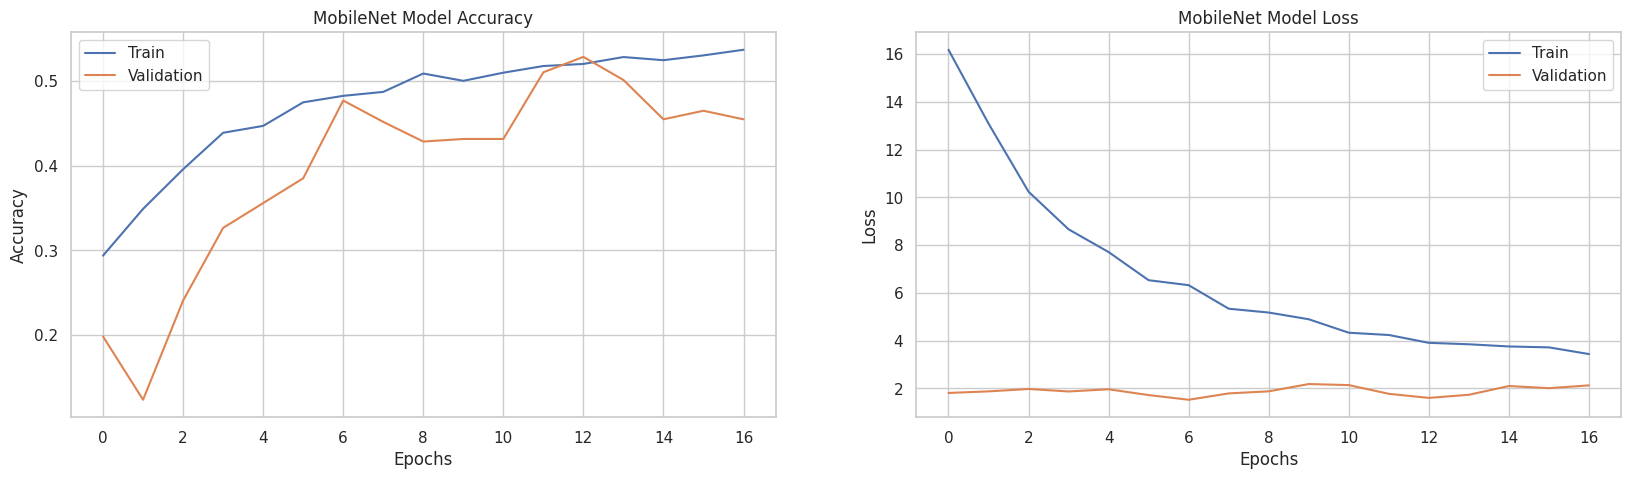

In [13]:





test_results_mobilenet = model_mobilenet.evaluate(test_ds)
print("Test Loss:", test_results_mobilenet[0])
print("Test Accuracy:", test_results_mobilenet[1])

# Plot training history
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history_mobilenet.history[met])
    ax[i].plot(history_mobilenet.history['val_' + met])
    ax[i].set_title(f'MobileNet Model {met.capitalize()}')
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(met.capitalize())
    ax[i].legend(['Train', 'Validation'])

plt.show()

# Mount Google Drive


In [14]:
from google.colab import drive
drive.mount('/content/drive')

# Specify the path in your Google Drive where you want to save the model
import os
model_save_path = '/content/drive/My Drive/mobilenet.h5'

# Save the model
model_mobilenet.save(model_save_path)
print(f"Model saved to {model_save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /content/drive/My Drive/mobilenet.h5


In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict the classes for the test dataset
test_ds.reset()
predictions = model_mobilenet.predict(test_ds, steps=test_ds.samples // BATCH_SIZE + 1)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true classes
true_classes = test_ds.classes

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
class_report = classification_report(true_classes, predicted_classes, target_names=CLASSES)
print("Classification Report:")
print(class_report)

40/40 [==============================] - 18s 405ms/step
Confusion Matrix:
[[  0   2  34 143]
 [  0   0   3   9]
 [  2   3 118 517]
 [  1   0  92 355]]
Classification Report:
                  precision    recall  f1-score   support

     NonDemented       0.00      0.00      0.00       179
VeryMildDemented       0.00      0.00      0.00        12
    MildDemented       0.48      0.18      0.27       640
ModerateDemented       0.35      0.79      0.48       448

        accuracy                           0.37      1279
       macro avg       0.21      0.24      0.19      1279
    weighted avg       0.36      0.37      0.30      1279

